<center><h1>Поиск параметров модели Орнштейна-Уленбека по двум коинтегрирующим активам</h1></center>

In [110]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm

In [111]:
gld = pd.read_csv("GLD.csv")["Close"]
slv = pd.read_csv("SLV.csv")["Close"]
df = pd.DataFrame()
df["gld"] = gld
df["slv"] = slv
print(df.shape)
df.head()

(199, 2)


,gld,slv
0,157.720001,38.290001
1,161.520004,39.820000
2,161.490005,40.549999
3,160.639999,37.610001
4,161.750000,37.320000


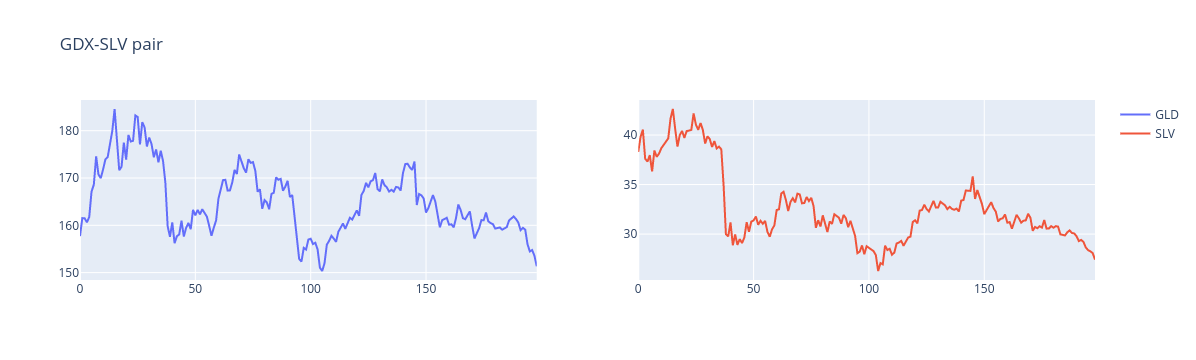

In [112]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(y=df["gld"], name='GLD'), row=1, col=1)
fig.add_trace(go.Scatter(y=df["slv"], name='SLV') , row=1, col=2)
fig.update_layout(title="GDX-SLV pair")
fig.show()

<center><h2>Анализ параметров процесса Орншейна-Уленбека</h2></center>

Модель Орнштейна-Уленбека имеет вид:

$$dx_{t}=-\theta\left(\mu-x_{t}\right)dt+\sigma dW_{t}$$

Переходя к дискретному времени имеем следующее:

$$x_{t+1}-x_{t}=-\theta\left(\mu-x_{t}\right)\triangle t+\sigma\triangle W_{t}$$

Мы можем моделировать данный процесса следующим образом:

$$x_{t+1}=x_{t}-\theta\left(\mu-x_{t}\right)\triangle t+\sigma\triangle W_{t}$$

In [113]:
def simulate_ornstein_ulenbeck(theta, mu, dt, sigma, time_len):
    trajectory = np.zeros((time_len, ))
    for i in range(time_len - 1):
        trajectory[i + 1] = trajectory[i] + theta * (mu - trajectory[i]) * dt + dt * np.random.normal(0, sigma)
    return trajectory

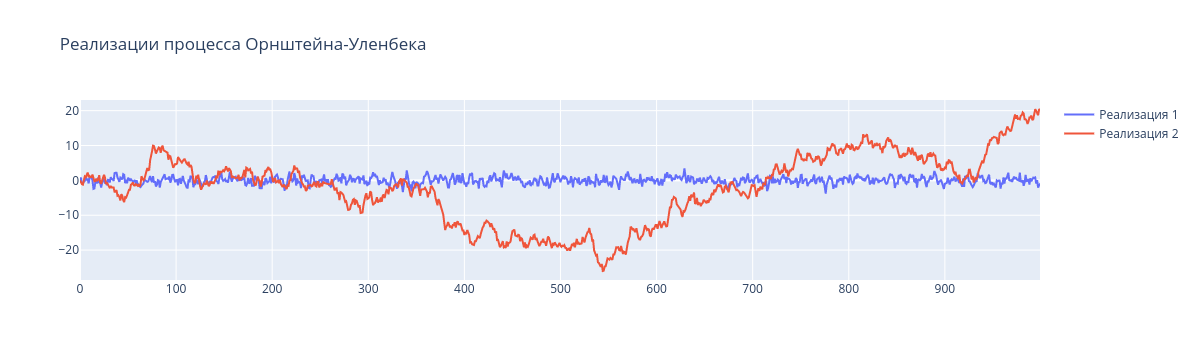

In [114]:
traj1 = simulate_ornstein_ulenbeck(theta=0.5, mu=0, dt=1, sigma=1, time_len=1000)
traj2 = simulate_ornstein_ulenbeck(theta=0.0001, mu=0, dt=1, sigma=1, time_len=1000)
fig = go.Figure(data=[
    go.Scatter(y=traj1, name="Реализация 1"), 
    go.Scatter(y=traj2, name="Реализация 2")
])
fig.update_layout(title="Реализации процесса Орнштейна-Уленбека")
fig.show()

Параметры процесса:

$\mu$ - Асимптотическое среднее

$\theta$ - Степень скорости роста в зависимости от возмущения(чем больше, тем дольше процесс откликается на возмущение)

$\triangle t$ - Период дискретизации

$W_{t}$ - Движение Броуна, где $\triangle W_{t}\sim N(0,\sigma^{2})$

Динамическое среднее процесса Орншейта-Уленбека:
Динамическое среднее процесса Орншейта-Уленбека $E(x_{0})=x_{0}e^{-\theta t}+\mu\left(1-e^{-\theta t}\right)$

In [115]:
def get_ou_time_varying_mean(theta, mu, dt, time_len):
    ou_mean = np.zeros((time_len, ))
    x0 = ou_mean[0]
    for i in range(time_len - 1):
        ou_mean[i + 1] = x0 * np.exp(-theta * i * dt) + mu * (1 - np.exp(- theta * i * dt))
    return ou_mean
traj = simulate_ornstein_ulenbeck(theta=0.01, mu=5, dt=1, sigma=0.05, time_len=5000)  
traj_mean = get_ou_time_varying_mean(theta=0.01, mu=5, dt=1, time_len=5000)

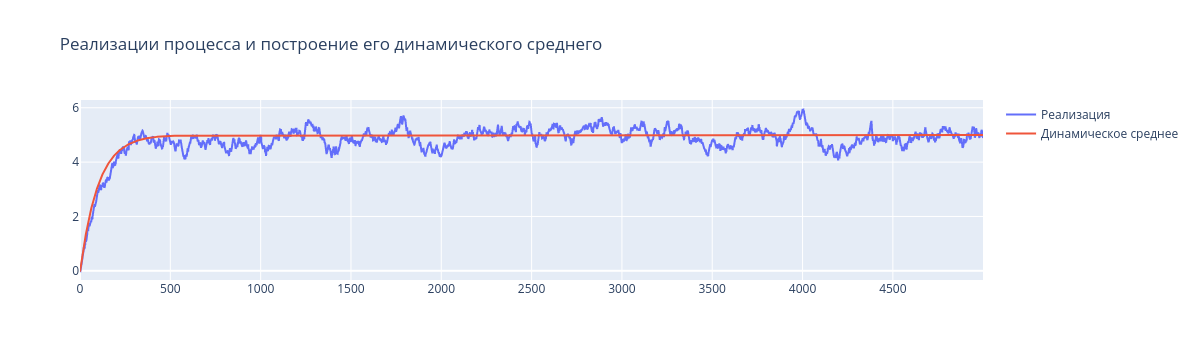

In [116]:
fig = go.Figure(data=[
    go.Scatter(y=traj, name="Реализация"), 
    go.Scatter(y=traj_mean, name="Динамическое среднее")
])
fig.update_layout(title="Реализации процесса и построение его динамического среднего")
fig.show()

<center><h2>Поиск параметров ОУ, которые оптимально аппроксимируют спред</h2></center>

Условная функция плотности вероятности перейти в состояние $x_{i}$ от состояния $x_{i-1}$ задаются уравнением
$$f^{OU}\left(x_{i}|x_{i-1};\theta,\mu,\sigma\right)=\frac{1}{\sqrt{2\pi\widetilde{\sigma}^{2}}}exp\left(-\frac{x_{i}-x_{i-1}e^{-\theta\triangle t}-\mu\left(1-e^{-\theta\triangle t}\right)}{2\widetilde{\sigma}^{2}}\right)$$
где $\widetilde{\sigma}=\sigma\frac{1-e^{-2\mu\triangle t}}{2\mu}$
Чтобы оценить параметры модели мы используем наблюдения x. В качестве критерия используется максимум усредненого логарифма правдоподобия

Используя наблюдения случайного процесса x_{i} мы максимизируем критерий согласно формуле:

$$L\left(\theta,\mu,\sigma|x_{0},x_{1},...x_{n}\right)=\frac{1}{n}\sum_{i=0}^{n}lnf^{OU}\left(x_{i}|x_{i-1};\theta,\mu,\sigma\right)=-\frac{1}{2}ln\left(2\pi\right)-ln\left(\widetilde{\sigma}\right)-\frac{1}{2n\widetilde{\sigma}^{2}}\sum_{i=1}^{n}\left(x_{i}-x_{i-1}e^{-\theta\triangle t}-\mu\left(1-e^{-\theta\triangle t}\right)\right)^{2}$$

Максимально правдободобные оценки имеет вид:
$$\hat{\theta}=\frac{X_{y}X_{xx}-X_{x}X_{xy}}{n\left(X_{xx}-X_{xy}\right)-\left(X_{x}^{2}-X_{x}X_{y}\right)}$$

$$\hat{\mu}=-\frac{1}{\triangle t}ln\left(\frac{X_{xy}-\hat{\theta}X_{x}-\hat{\theta}X_{y}+n\hat{\theta}^{2}}{X_{xx}-2\hat{\theta}X_{x}+n\hat{\theta}^{2}}\right)$$

$$\hat{\sigma}^{2}=\frac{2\hat{\mu}}{n\left(1-e^{-2\hat{\mu}\triangle t}\right)}\left[X_{yy}-2e^{-\hat{\mu}\triangle t}X_{xy}+e^{-2\hat{\mu}\triangle t}X_{xx}-2\hat{\theta}\left(1-e^{-\hat{\mu}\triangle t}\right)\left(X_{y}-e^{-\hat{\mu}\triangle t}X_{x}\right)+n\hat{\theta}^{2}\left(1-e^{-\hat{\mu}\triangle t}\right)^{2}\right]$$


где

$X_{x}=\sum_{i=1}^{n}x_{i-1}$  

$X_{y}=\sum_{i=1}^{n}x_{i}$  

$X_{xx}=\sum_{i=1}^{n}\left(x_{i-1}\right)^{2}$ 

$X_{xy}=\sum_{i=1}^{n}x_{i-1}x_{i}$

$X_{yy}=\sum_{i=1}^{n}\left(x_{i}\right)^{2}$

<center>Практическая оценка параметров модели Орншейна-Уленбека(Тестирование)</h2></center>

In [117]:
class OuEstimator:
    def __init__(self, first_asset, second_asset, step_size):
        assert len(first_asset) == len(second_asset), "Интервалы реализаций должны быть одинаковыми"
        self.first_asset = first_asset
        self.second_asset = second_asset
        self.weight = self.init_b(step_size)
        self.n = len(first_asset) - 1
        self.dt = 1 / self.n
        self.s00 = self.first_asset[0] 
        self.s01 = self.second_asset[0]
        
        self.params = {
            "theta": [],
            "mu": [],
            "var": []
        }
        
    def init_b(self, step_size):
        return np.arange(step_size, 1, step_size)
    
    def get_X_x(self, x_prev): #x[i - 1]
        return np.sum(x_prev)
    
    def get_X_y(self, x_cur): #x[i]
        return np.sum(x_cur)
    
    def get_X_xx(self, x_prev): #x[i - 1]
        return np.sum(np.power(x_prev, 2))
    
    def get_X_xy(self, x_prev, x_cur): #x[i - 1], x[i]
        return np.sum(x_prev * x_cur)
    
    def get_X_yy(self, x_cur): #x[i]
        return np.sum(np.power(x_cur, 2))
    
    def get_theta(self, X_x, X_y, X_xx, X_xy, X_yy):
        theta = (X_y * X_xx - X_x * X_xy) / (self.n * (X_xx - X_xy) - (X_x ** 2 - X_x * X_y))
        
        return theta
    
    def get_mu(self, X_x, X_y, X_xx, X_xy, theta):
        numerator = X_xy - theta * X_x - theta * X_y + self.n * np.power(theta, 2)
        denumerator = X_xx - 2 * theta * X_x + self.n * np.power(theta, 2)
        
        return - 1 / self.dt * np.log(numerator / denumerator)
    
    def get_var(self, X_x, X_y, X_xx, X_xy, X_yy, theta, mu):
        term1 = X_yy - 2 * np.exp(-mu * self.dt) * X_xy + np.exp(-2 * mu * self.dt) * X_xx - \
                2 * theta * (1 - np.exp(-mu * self.dt)) * (X_y - np.exp(-mu * self.dt) * X_x) + \
                self.n * np.power(theta, 2) * np.power(1 - np.exp(- mu * self.dt), 2)
        
        term2 = 2 * mu / (self.n * (1 - np.exp(- 2 * mu * self.dt)))
        
        return term1 * term2
    
    def get_params(self, spread):
        X_x = self.get_X_x(spread[:self.n])
        X_y = self.get_X_y(spread[1:self.n + 1])
        X_xx = self.get_X_xx(spread[:self.n])
        X_xy = self.get_X_xy(spread[:self.n], spread[1:self.n + 1])
        X_yy = self.get_X_yy(spread[1:self.n + 1])
        
        theta = self.get_theta(X_x=X_x, X_y=X_y, X_xx=X_xx, X_xy=X_xy, X_yy=X_yy)
        mu = self.get_mu(X_x=X_x, X_y=X_y, X_xx=X_xx, X_xy=X_xy, theta=theta)
        var = self.get_var(X_x=X_x, X_y=X_y, X_xx=X_xx, X_xy=X_xy, X_yy=X_yy, theta=theta, mu=mu)
        s_var = self.get_scaled_var(var=var, mu=mu)
        
        self.params["theta"].append(theta)
        self.params["mu"].append(mu)
        self.params["var"].append(var)
        
        return theta, mu, var
        
    def get_scaled_var(self, var, mu):
        return var * (1 - np.exp(-2 * mu * self.dt)) / (2 * mu)
            
    def get_average_likelhood(self, theta, s_var, mu, spread):
        const_term = - 0.5 * np.log(2 * np.pi) - np.log(s_var)
        multiplier = 1 / (2 * self.n * s_var)
        cumulative_term = 0
        for i in range(1, self.n + 1):
            cur_term = spread[i] - spread[i - 1] * np.exp(-mu * self.dt) - theta * (1 - np.exp(-mu * self.dt))
            cumulative_term += np.power(cur_term, 2)
            
        return const_term - multiplier * cumulative_term
    
    def get_solution(self):
        avarege_likelhood = []
        for beta in tqdm(self.weight):
            spread = 1 / self.s00 * self.first_asset - beta / self.s01 * self.second_asset
            theta, mu, s_var = self.get_params(spread)
            cur_av_likelhood = self.get_average_likelhood(theta, s_var, mu, spread)
            avarege_likelhood.append(cur_av_likelhood)
            
        return self.weight, avarege_likelhood
    
    def get_results(self):
        return self.params
            
            
ou_estimator = OuEstimator(df["gld"].values, df["slv"].values, 0.001) 
shares, average_likelhood = ou_estimator.get_solution()

  0%|          | 0/999 [00:00<?, ?it/s]

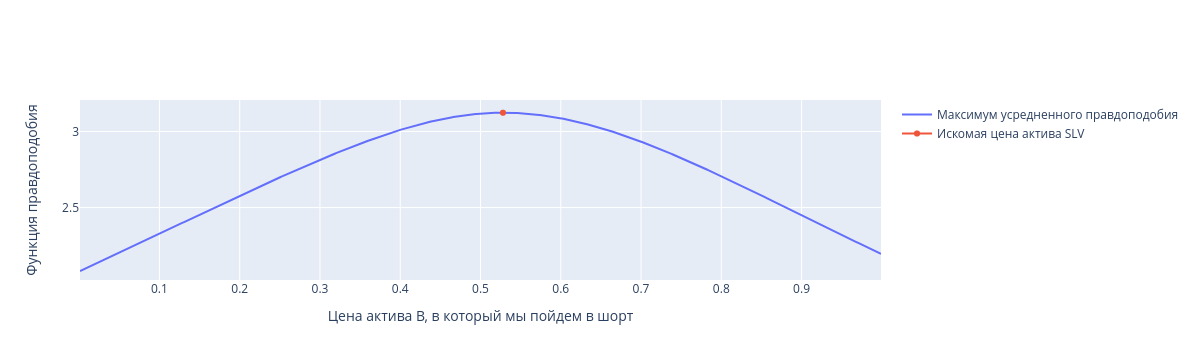

In [118]:
fig = go.Figure(data=[
    go.Scatter(x=shares, y=average_likelhood, name='Максимум усредненного правдоподобия'),
    go.Scatter(x=[shares[np.argmax(average_likelhood)]], y=[np.max(average_likelhood)], name="Искомая цена актива SLV")
])
fig.update_xaxes(title="Цена актива B, в который мы пойдем в шорт")
fig.update_yaxes(title="Функция правдоподобия")
fig.show()
# Положим что мы идем в лонг по активу GLD в 1$. Функция показывает какую сумму мы должны в вложить в актив B(SLV)
# Чтобы параметры модели были такие, что она наибольшим образом соответствует модели Орнштейна-Уленбека

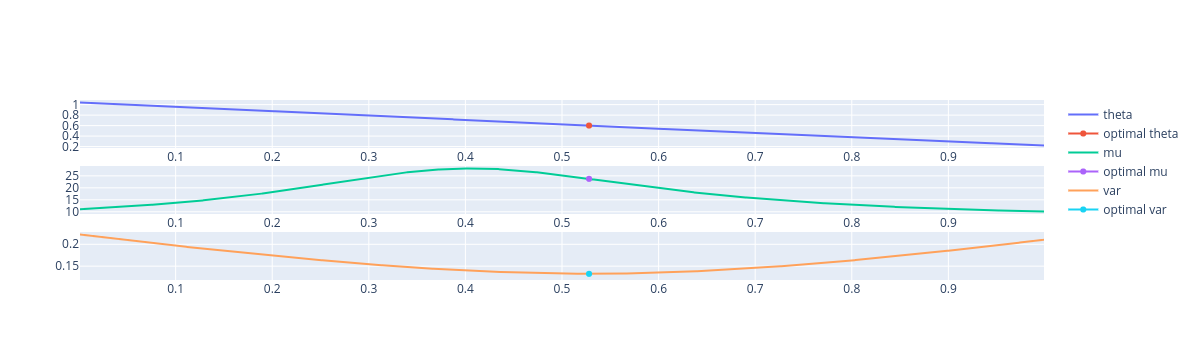

In [119]:
params = ou_estimator.get_results()
optimial_theta = [params["theta"][np.argmax(average_likelhood)]]
optimial_mu = [params["mu"][np.argmax(average_likelhood)]]
optimial_var = [np.sqrt(params["var"][np.argmax(average_likelhood)])]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=shares, y=params["theta"], name="theta"), row=1, col=1)
fig.add_trace(go.Scatter(x=[shares[np.argmax(average_likelhood)]], y=optimial_theta, name="optimal theta"), row=1, col=1)

fig.add_trace(go.Scatter(x=shares, y=params["mu"], name="mu"), row=2, col=1)
fig.add_trace(go.Scatter(x=[shares[np.argmax(average_likelhood)]], y=optimial_mu, name="optimal mu"), row=2, col=1)

fig.add_trace(go.Scatter(x=shares, y=np.sqrt(params["var"]), name="var"), row=3, col=1)
fig.add_trace(go.Scatter(x=[shares[np.argmax(average_likelhood)]], y=optimial_var, name="optimal var"), row=3, col=1)

fig.show()